### Import & load    

In [1]:
from datasets import load_dataset
import numpy as np
from datasets import load_metric
import pandas as pd
from datasets import Dataset
import os

df_train = pd.read_csv('../input/yelp-reviews-for-sa-finegrained-5-classes-csv/yelp_review_fine-grained_5_classes_csv/train.csv')
df_test = pd.read_csv('../input/yelp-reviews-for-sa-finegrained-5-classes-csv/yelp_review_fine-grained_5_classes_csv/test.csv')
os.makedirs("kaggle/tmp", exist_ok=True)

### Sampling, selection and columns renaming

In [2]:
df_train = df_train.groupby('class_index', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=0))
df_train['class_index'] -= 1 # because labels rage should be from 0 to 4 while class_index range is: (1,5)
df_test = df_test.groupby('class_index', group_keys=False).apply(lambda x: x.sample(frac=0.08, random_state=0))
df_test['class_index'] -= 1 
df_train.rename(columns={'review_text':'text'}, inplace=True)
df_test.rename(columns={'review_text':'text'}, inplace=True)
metric = load_metric("accuracy")
len(df_test)/(len(df_train)+len(df_test))

0.1095890410958904

In [3]:
#our_df = df[['class_index','text']]
df_train.head()

,class_index,text
19492,0,I was disgusted this morning to drive by and s...
520976,0,This place was the worst place I ever went to....
556640,0,"went to dal toro for breakfast with my wife, a..."
182757,0,Bullshit service. .. everything felt like it w...
66780,0,This Target makes me feel like i'm in a Walmar...


In [4]:
df_train.describe()

,class_index
count,32500.000000
mean,2.000000
std,1.414235
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


### Load & extract only text + labels

In [5]:
df_train['text'].isna().sum()

0

In [6]:
df_test['text'].isna().sum()

0

Okay, we have no missing values

### Basic EDA

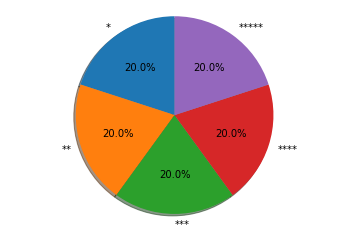

<Figure size 1080x720 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

labels = ['*','**','***','****','*****']
texts = []
for i in range(5):
    texts.append(df_train[df_train['class_index'] == i]['text'].reset_index())
    texts[i].drop(['index'],axis=1, inplace=True)
fig1, ax1 = plt.subplots()
sizes = [len(texts[i]) for i in range(5)]
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figure( figsize=(15,10) )
plt.show()

#### Example reviews  

In [8]:
for i in range(4):
    print('\033[1m{} star rewiew \033[0m \n'.format(i+1))
    print(texts[i]['text'][134], '\n')

1 star rewiew  

My fiance and I took our dog here during an emergency and were turned away because the vet was busy eating lunch.  This place is only a few blocks from our home and we rushed to the nearest place possible because our dog was having a seizure and was unable to stand up.   We were told drive to the university emergency pet clinic which is a ten minute drive.  The vet also had a lot of appointments coming and was \"very busy\".  There was not a single car in the parking lot nor a single room occupied. \n\nWe pleaded with them to at least check his vitals and make sure he would be OK, they again turned us down.  I cannot speak to the quality of either the vets there because we were never given a chance to see them.  The staff was unprofessional. 

2 star rewiew  

So, I've enjoyed Mi Cocina before.... but I think my tastes have matured.  The salsa was good, but the sauce inside of my taco and chimichanga was a strange ketchup/bbq tasting mixture.  Beans were ok, rice, not 

### Prepaare data for BERT-like model  

In [9]:
dataset = Dataset.from_pandas(df_train[["class_index", "text"]])
dataset = dataset.train_test_split(test_size=0.2)

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['class_index', 'text', '__index_level_0__'],
        num_rows: 26000
    })
    test: Dataset({
        features: ['class_index', 'text', '__index_level_0__'],
        num_rows: 6500
    })
})

In [11]:
dataset['train'][0]

{'class_index': 1,
 'text': "I didn't know what to make of this place after having walked past a number of times, and after eating there, I still don't know.\\n\\nService was ok. Our server and hostess were a bit on the awkward side (asked if we had a reservation at 11:30am), but I won't demote anyone for that.\\n\\nFood was expensive. I would like to try the pizza, but the salads, sandwiches and steaks were just not grabbing me off the menu. There was nothing particularly pittsburgher, which I expected given the name of the place. I settled for a grilled romaine salad, and that's what I got, nothing spectacular.\\n\\nThe atmosphere is quite unique, as many have described, but I would put it somewhere in the vicinity of sports bar meets the jetsons.\\n\\nI'll go back and give them another chance.",
 '__index_level_0__': 524184}

### Tokenize  

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")


def tokenize_function(examples):
    tokz = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    tokz.model_max_len = 256
    return tokz


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

### Baseline fine-tuning on classification in transformes is one string: AutoModelForSequenceClassification

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=5)#

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="deberta_trainer_30k_reviews",save_steps=3000, evaluation_strategy="epoch", per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=3, seed=42)

#### Predict to logit convertion (for compatibility with transformers)

In [15]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

###  Training 

In [16]:
#we could use small subsets or original
train_dataset = tokenized_datasets["train"].rename_column("class_index", "labels")#.shuffle(seed=42)

eval_dataset = tokenized_datasets["test"].rename_column("class_index", "labels")#.shuffle(seed=42)
from transformers import Trainer
trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=train_dataset,

    eval_dataset=eval_dataset,
    
    compute_metrics=compute_metrics
)
del tokenized_datasets

In [17]:
import torch
torch.cuda.empty_cache()
#in case you need
#torch.manual_seed(42)

In [18]:
import wandb
from kaggle_secrets import UserSecretsClient


API_KEY = UserSecretsClient().get_secret('wandb_api')
wandb.login(key=API_KEY)
#os.environ["WANDB_DISABLED"] = "true"
trainer.train()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
The following columns in the training set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.001600,0.935944,0.602000
2,0.811600,0.896147,0.634000
3,0.637400,0.924968,0.641077


Saving model checkpoint to deberta_trainer_30k_reviews/checkpoint-3000
Configuration saved in deberta_trainer_30k_reviews/checkpoint-3000/config.json
Model weights saved in deberta_trainer_30k_reviews/checkpoint-3000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6500
  Batch size = 8
Saving model checkpoint to deberta_trainer_30k_reviews/checkpoint-6000
Configuration saved in deberta_trainer_30k_reviews/checkpoint-6000/config.json
Model weights saved in deberta_trainer_30k_reviews/checkpoint-6000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: text, __i

TrainOutput(global_step=9750, training_loss=0.8684534739958935, metrics={'train_runtime': 7563.6584, 'train_samples_per_second': 10.312, 'train_steps_per_second': 1.289, 'total_flos': 2.3915165534208e+16, 'train_loss': 0.8684534739958935, 'epoch': 3.0})

### Score

In [19]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6500
  Batch size = 8


{'eval_loss': 0.9249678254127502,
 'eval_accuracy': 0.6410769230769231,
 'eval_runtime': 192.5032,
 'eval_samples_per_second': 33.766,
 'eval_steps_per_second': 4.223,
 'epoch': 3.0}

### Get predictions and evaluate  

In [20]:
eval_dataset

Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6500
})

In [21]:
cleaned_eval_dataset = eval_dataset.remove_columns("labels")
cleaned_eval_dataset.features

{'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

#### We have no labels in cleaned_eval_dataset so we can be sure model don't use them to get predictions 

In [22]:
predicted_logits = trainer.predict(cleaned_eval_dataset).predictions
predicted_labels = np.argmax(predicted_logits, axis=-1)
predicted_labels[:10]

The following columns in the test set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6500
  Batch size = 8


array([3, 2, 0, 3, 0, 2, 0, 2, 3, 3])

In [23]:
true_labels = eval_dataset['labels']
true_labels = np.array(true_labels)
true_labels[:10]

array([1, 3, 1, 2, 0, 1, 0, 2, 3, 4])

### Time for confusion matrix!  

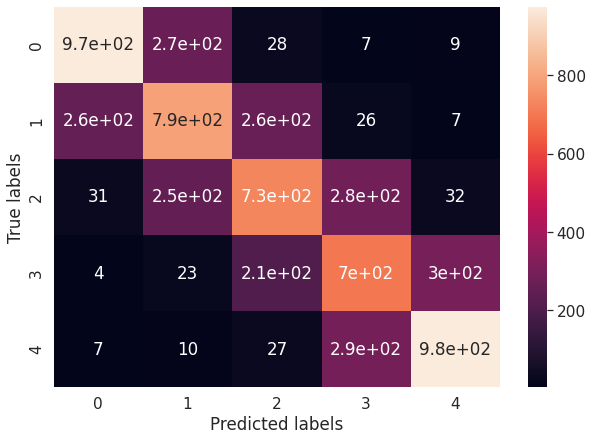

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


cm_array = confusion_matrix(true_labels, predicted_labels, labels=range(5))

df_cm = pd.DataFrame(cm_array, range(5), range(5))
plt.figure(figsize=(10,7))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### So model confuses very much between 4 and 5 class_index. Maybe we missing something? Or we could build another model for 4-5 class_index problem to get better results

### Analyse 4-5 star texts  

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Example 4 star and example 5 star reviews again:

In [26]:
print('4 satrs \n\n')
print(texts[3]['text'][134])

4 satrs 


Great place for live music. Excellent selection of local beers on tap, friendly staff.


In [27]:
print('5 satrs \n\n')
print(texts[4]['text'][134])

5 satrs 


I booked a stay at Hotel San Carlos for one night through Groupon for $76 after taxes. Most other hotels in the area go for $120-300, so finding this deal was awesome. My boyfriend and I live in AZ and he wanted to celebrate his birthday by having a staycation downtown so we could have fun with family and friends without worrying about a way to get home at the end of the night. Originally, we were going to book a night at Hotel Palomar but like I said, we weren't looking to spend a lot of money.\n\nI started reading reviews before we checked in and was feeling nervous that I hadn't made a good decision because there were more bad than good things being said. From the moment we got to the hotel to the time we checked out, our stay was anything from dissappointing. The staff was nice and let us check In early. Before we parked we talked to the valet service and asked for advice on parking. They could have given us excuses to use their service but instead, they pointed across t

There are 4425511 words in the combination of all 4 class_index reviews.


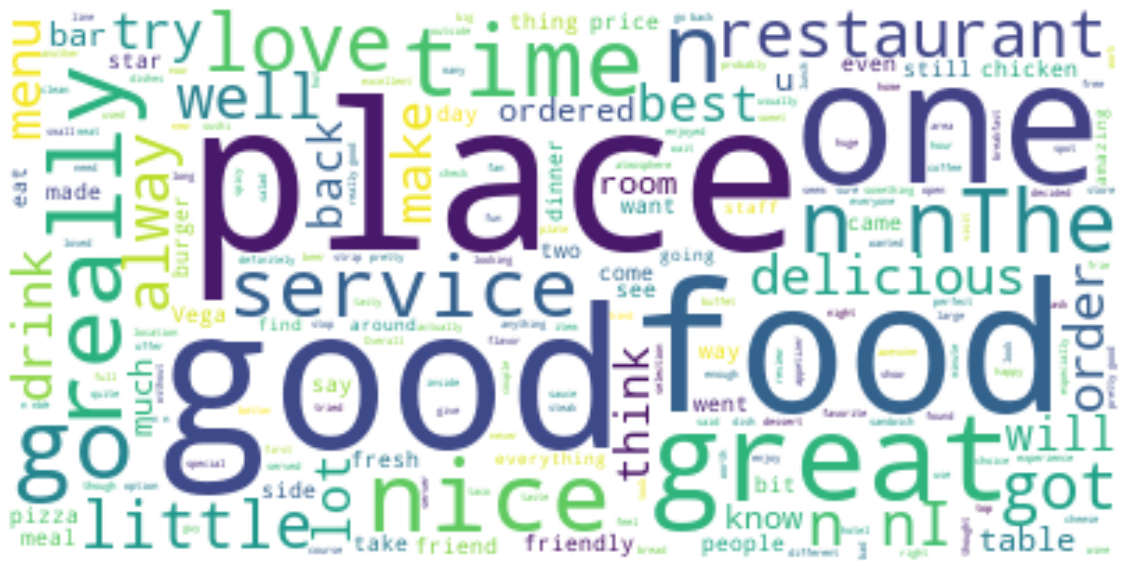

There are 3810921 words in the combination of all 5 class_index reviews.


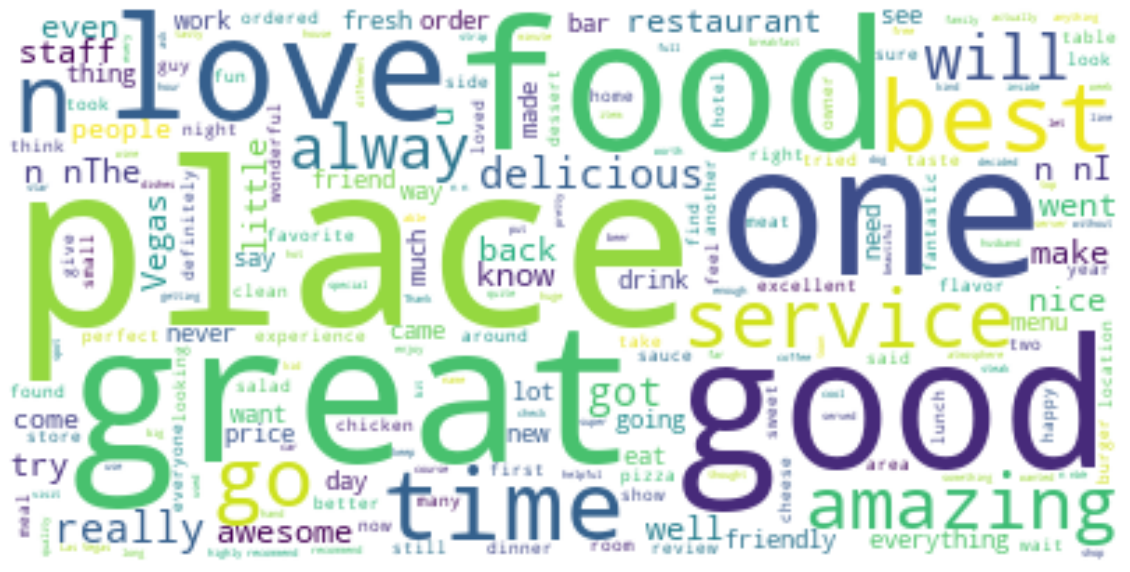

In [28]:
for i in range(3,5):
    text = " ".join(review for review in texts[i].text)
    print ("There are {} words in the combination of all {} class_index reviews.".format(len(text),i + 1))
    # Create stopword list:
    stopwords = set(STOPWORDS)

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure( figsize=(20,15) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### 'Best' 'Great' 'One' more commonly used in 5 class_index review, but they both in top10 for 4 and 5 class_index reviews

### Look at some 4-5 class_index misclassifications

In [29]:
misclass45_idx = np.argwhere((true_labels == 3)  & (predicted_labels == 4))
misclass45_idx = misclass45_idx.reshape(-1)
misclass45_text = eval_dataset[misclass45_idx]['text']
for elem in misclass45_text[:5]:
    print("TEXT WITH TRUE 4 class_index BUT CLASSIFIED AS 5\n")
    print(elem,'\n')

TEXT WITH TRUE 4 class_index BUT CLASSIFIED AS 5

Oh how I want to give 5 stars. Had I not had dessert, it would have been five. \n\nAmbiance is about as perfect as it can get in Vegas, love the view of the fountains. Staff and service exhibit perfection.\n\nTo date, probably the best meal experience ever. And their foie gras will ruin your expectations for any restaurant not up to this caliber. My husband will hardly order it anywhere now because he knows it won't be as good.\n\nDessert was very good, but not the best I've ever had and not the best way to end an otherwise exceptional meal. 

TEXT WITH TRUE 4 class_index BUT CLASSIFIED AS 5

Wow - such a great place!  We came in Saturday night for dinner and had a great experience.  The atmosphere is great - love the lighting and decor, the service is so professional and the food was fantastic.  I enjoyed the wedge salad, a delmonico steak, the mashed potatoes and the brussel sprouts.  I only wish I had left room to indulge in a red ve

In [30]:
misclass54_idx = np.argwhere((true_labels == 4)  & (predicted_labels == 3))
misclass54_idx = misclass54_idx.reshape(-1)
misclass54_text = eval_dataset[misclass54_idx]['text']
for elem in misclass54_text[:5]:
    print("TEXT WITH TRUE 4 class_index BUT CLASSIFIED AS 5\n")
    print(elem, '\n')

TEXT WITH TRUE 4 class_index BUT CLASSIFIED AS 5

Hands down the best Chicken Katsu in Las Vegas! The Katsu sauce is really what makes it even better! Their portions here are big so it is well worth your money that you pay for it! \n\nSince I moved here from Hawaii 7 yrs ago, I was always craving plate lunches like at L&L and was glad to find one here, but I was really disappointed with the food there. It was overpriced and greasy....I'll write a review on that one later! We stumbled upon this place when I was working at Smoothie King across the street, my parents were waiting for me to get off work and ate there, of course getting me a Katsu Plate to go. I was a regular there quite frequently. Some of my other favorites was the Mahi Mahi plate, Loco Moco, Teriyaki Chicken Burger, Katsu Curry (Chicken Katsu plate with Curry on top), and Teri Chicken plate! \n\nThey served Poke here once in a while and the Chantilly Cocoa Puffs too!! \n\nIts sad to say that they have closed down on Dece